In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc

Read in data as preprocessed for Dahlin et al. (2018).

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()
results_file = './write/paul15.h5ad'
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white')  # low dpi (dots per inch) yields small inline figures

In [3]:
adata = sc.datasets.paul15()

C:\Users\gubow\anaconda3\lib\site-packages\anndata\_core\anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'paul15_clusters' as categorical
C:\Users\gubow\anaconda3\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.uns` of view, copying.


In [4]:
print(adata.var)

Empty DataFrame
Columns: []
Index: [0610007L01Rik, 0610009O20Rik, 0610010K14Rik, 0910001L09Rik, 1100001G20Rik, 1110002B05Rik, 1110004E09Rik, 1110007A13Rik, 1110007C09Rik, 1110013L07Rik, 1110020G09Rik, 1110034G24Rik, 1110038B12Rik, 1110049F12Rik, 1110059E24Rik, 1190002H23Rik, 1190007F08Rik, 1200002N14Rik, 1300001I01Rik, 1300017J02Rik, 1500001M20Rik, 1500012F01Rik, 1500032L24Rik, 1600014C10Rik, 1700001L05Rik, 1700012B09Rik, 1700017B05Rik, 1700020L24Rik, 1810009A15Rik, 1810011H11Rik, 1810027O10Rik, 1810030N24Rik, 1810031K17Rik, 1810033B17Rik, 1810037I17Rik, 2010002N04Rik, 2010011I20Rik, 2010106G01Rik, 2210016F16Rik, 2210020M01Rik, 2210023G05Rik, 2210404O07Rik, 2210411K11Rik, 2310003C23Rik, 2310003F16Rik, 2310005E10Rik, 2310014H01Rik, 2310022B05Rik, 2310028O11Rik, 2410006H16Rik, 2510002D24Rik, 2510003E04Rik, 2610018G03Rik, 2610024G14Rik, 2610029G23Rik, 2610029I01Rik, 2610035D17Rik, 2610101N10Rik, 2700094K13Rik, 2810004N23Rik, 2810417H13Rik, 2810474O19Rik, 2900010J23Rik, 2900010M23Rik, 2900

Let us work with a higher precision than the default ‘float32’ to ensure exactly the same results across different computational platforms.

In [5]:
adata.X = adata.X.astype('float64')  # this is not required and results will be comparable without it

# Preprocessing and Visualization


Apply a simple preprocessing recipe.

In [6]:
sc.pp.recipe_zheng17(adata) # Normalization and filtering as of [Zheng17].

running recipe zheng17
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


C:\Users\gubow\anaconda3\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
    finished (0:00:00)


C:\Users\gubow\anaconda3\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [7]:
sc.tl.pca(adata, svd_solver='arpack') # Principal component analysis [Pedregosa11]
                                      # svd_solver : 'arpack' (the default): for the ARPACK wrapper in SciPy (svds())

computing PCA
    with n_comps=50
    finished (0:00:00)


In [8]:
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20) # Compute a neighborhood graph of observations [McInnes18].
# pp: Preprocessing
# n_neighbors: The size of local neighborhood (in terms of number of neighboring data points) used 
# for manifold approximation. Larger values result in more global views of the manifold,
# while smaller values result in more local data being preserved. 
# In general values should be in the range 2 to 100. 
# n_pcs: Use this many PCs.
sc.tl.draw_graph(adata)
# tl: tools
# draw_graph: Force-directed graph drawing [Islam11] [Jacomy14] [Chippada18]

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:14)


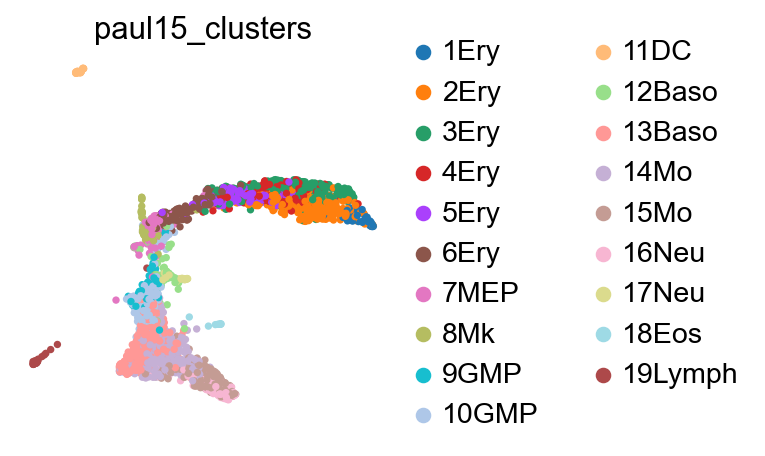

In [9]:
sc.pl.draw_graph(adata, color='paul15_clusters', legend_loc='right margin', show = True)
# pl: plotting. For most tools(tl) and for some preprocessing(pp) functions, 
# you’ll find a plotting function with the same name.
# draw_graph: Scatter plot in graph-drawing basis.

This looks pretty messy.

# Optional: Denoising the graph

To denoise the graph, we represent it in diffusion map space (and not in PCA space). Computing distances within a few diffusion components amounts to denoising the graph - we just take a few of the first spectral components. It's very similar to denoising a data matrix using PCA. The approach has been used in a couple of papers, see e.g. Schiebinger et al. (2017) or Tabaka et al. (2018). It's also related to the principles behind MAGIC Dijk et al. (2018)

**Note:** This is *not* a necessary step, neither for PAGA, nor clustering, nor pseudotime estimation. You might just as well go ahead with a non-denoised graph. In many situations (also here), this will give you very decent results. 

In [10]:
sc.tl.diffmap(adata)
# diffmap: Diffusion Maps [Coifman05] [Haghverdi15] [Wolf18].
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')
# use_rep: Use the indicated representation. 
# 'X' or any key for .obsm is valid. 
# If None, the representation is chosen automatically: 
# For .n_vars < 50, .X is used, otherwise ‘X_pca’ is used. 
# If ‘X_pca’ is not present, it’s computed with default parameters.

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         1.         0.9989278  0.99671    0.99430376 0.98939794
     0.9883687  0.98731077 0.98398703 0.983007   0.9790806  0.9762548
     0.9744365  0.9729161  0.9652972 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [11]:
sc.tl.draw_graph(adata) # draw the graph again after denoising

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:12)


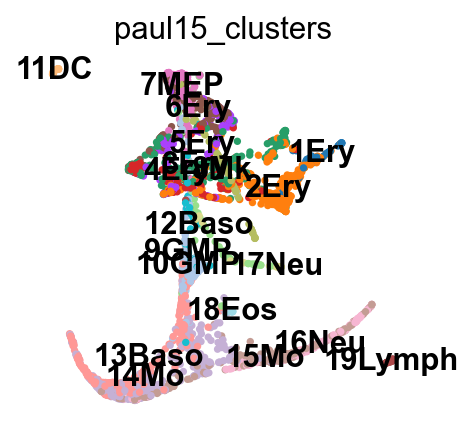

In [12]:
sc.pl.draw_graph(adata, color='paul15_clusters', legend_loc='on data') # show the graph again after denoising

This still looks messy, but in a different way: a lot of the branches are overplotted.

# Clustering and PAGA

**Note:** Note that today, we'd use `sc.tl.leiden` - here, we use `sc.tl.louvain` the sake of reproducing the paper results. 

In [13]:
sc.tl.louvain(adata, resolution=1.0)
# louvain: Cluster cells into subgroups [Blondel08] [Levine15] [Traag17].
# resolution: For the default flavor ('vtraag'), 
# you can provide a resolution (higher resolution means finding more and smaller clusters), 
# which defaults to 1.0. See “Time as a resolution parameter” in [Lambiotte09].

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 25 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


Annotate the clusters using marker genes.

| **cell type** | **marker** |
| --- | --- |
| HSCs | Procr |
| Erythroids| Gata1, Klf1, Epor, Gypa, Hba-a2, Hba-a1, Spi1 |
| Neutrophils| Elane, Cebpe, Ctsg, Mpo, Gfi1 |
| Monocytes| Irf8, Csf1r, Ctsg, Mpo |
| Megakaryocytes| Itga2b (encodes protein CD41), Pbx1, Sdpr, Vwf |
| Basophils| Mcpt8, Prss34 |
| B cells| Cd19, Vpreb2, Cd79a |
| Mast cells| Cma1, Gzmb, CD117/C-Kit |
| Mast cells & Basophils | Ms4a2, Fcer1a, Cpa3, CD203c (human) |

For simple, coarse-grained visualization, compute the PAGA graph, a coarse-grained and simplified (abstracted) graph. Non-significant edges in the coarse- grained graph are thresholded away.

In [14]:
sc.tl.paga(adata, groups='louvain')
# paga: Mapping out the coarse-grained connectivity structures of complex manifolds [Wolf19].

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


C:\Users\gubow\anaconda3\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
C:\Users\gubow\anaconda3\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
C:\Users\gubow\anaconda3\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


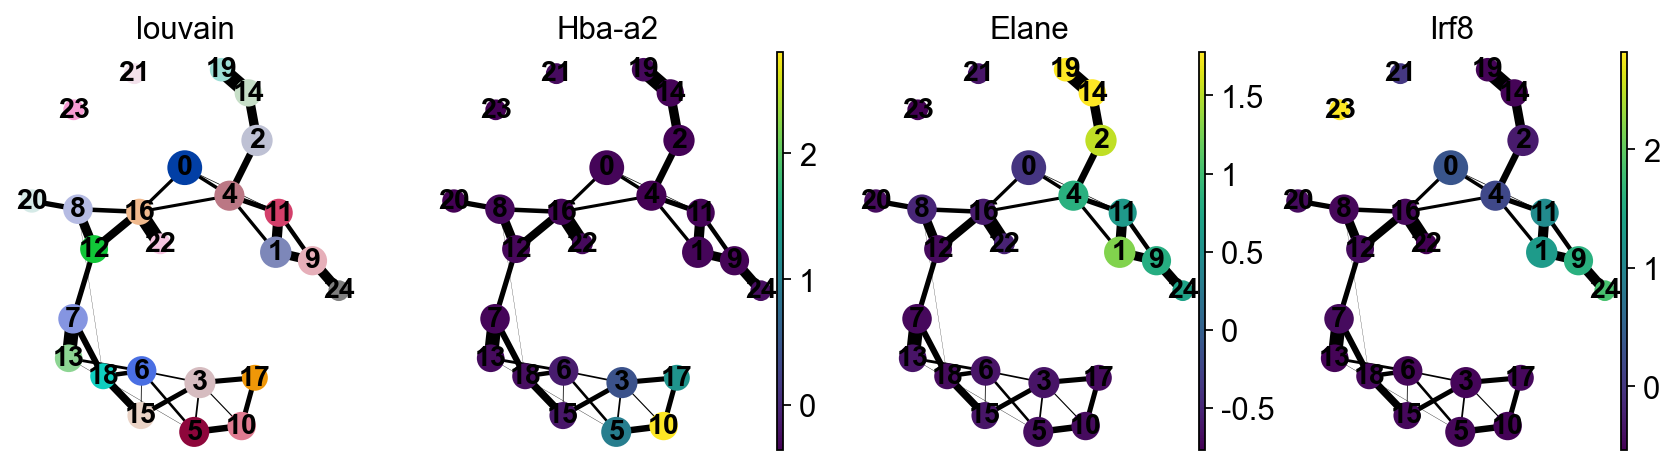

In [15]:
sc.pl.paga(adata, color=['louvain', 'Hba-a2', 'Elane', 'Irf8'])
# show plots in terms of cell markers

--> added 'pos', the PAGA positions (adata.uns['paga'])


C:\Users\gubow\anaconda3\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
C:\Users\gubow\anaconda3\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
C:\Users\gubow\anaconda3\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


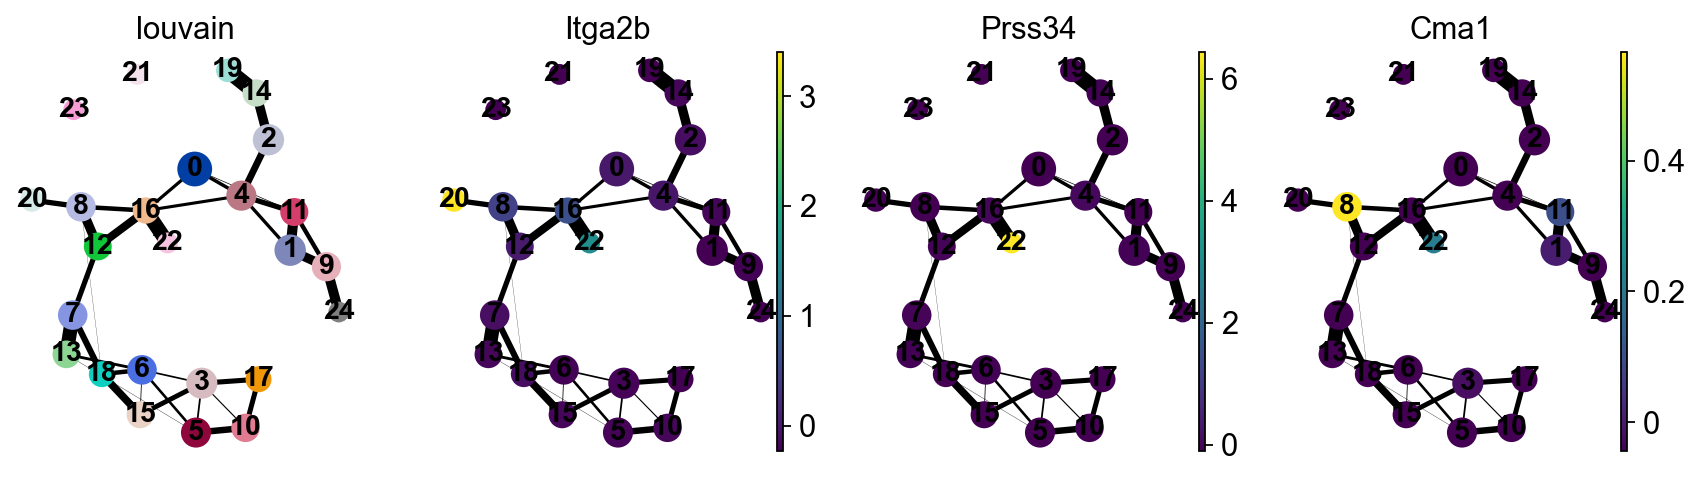

In [16]:
sc.pl.paga(adata, color=['louvain', 'Itga2b', 'Prss34', 'Cma1'])

Actually annotate the clusters --- note that Cma1 is a Mast cell marker and only appears in a small fraction of the cells in the progenitor/stem cell cluster 8, see the single-cell resolved plot below.

In [17]:
adata.obs['louvain'].cat.categories

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24'],
      dtype='object')

In [18]:
adata.obs['louvain_anno'] = adata.obs['louvain']

In [19]:
adata.obs['louvain_anno'].cat.categories = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10/Ery', '11', '12',
       '13', '14', '15', '16/Stem', '17', '18', '19/Neu', '20/Mk', '21', '22/Baso', '23', '24/Mo']

Let's use the annotated clusters for PAGA.

In [20]:
sc.tl.paga(adata, groups='louvain_anno') 
# change group from louvain to louvain_anno

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


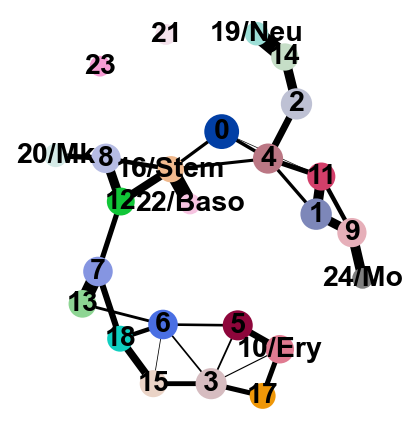

In [21]:
sc.pl.paga(adata, threshold=0.03, show=False)
# threshold: Do not draw edges for weights below this threshold. Set to 0 if you want all edges. Discarding low-connectivity edges helps in getting a much clearer picture of the graph.
# show: Show the plot, do not return axis.

# Recomputing the embedding using PAGA-initialization

The following is just as well possible for a UMAP.

In [22]:
sc.tl.draw_graph(adata, init_pos='paga')
# init_pos: 'paga'/True, None/False, or any valid 2d-.obsm key. 
# Use precomputed coordinates for initialization. 
# If False/None (the default), initialize randomly.

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:12)


Now we can see all marker genes also at single-cell resolution in a meaningful layout.

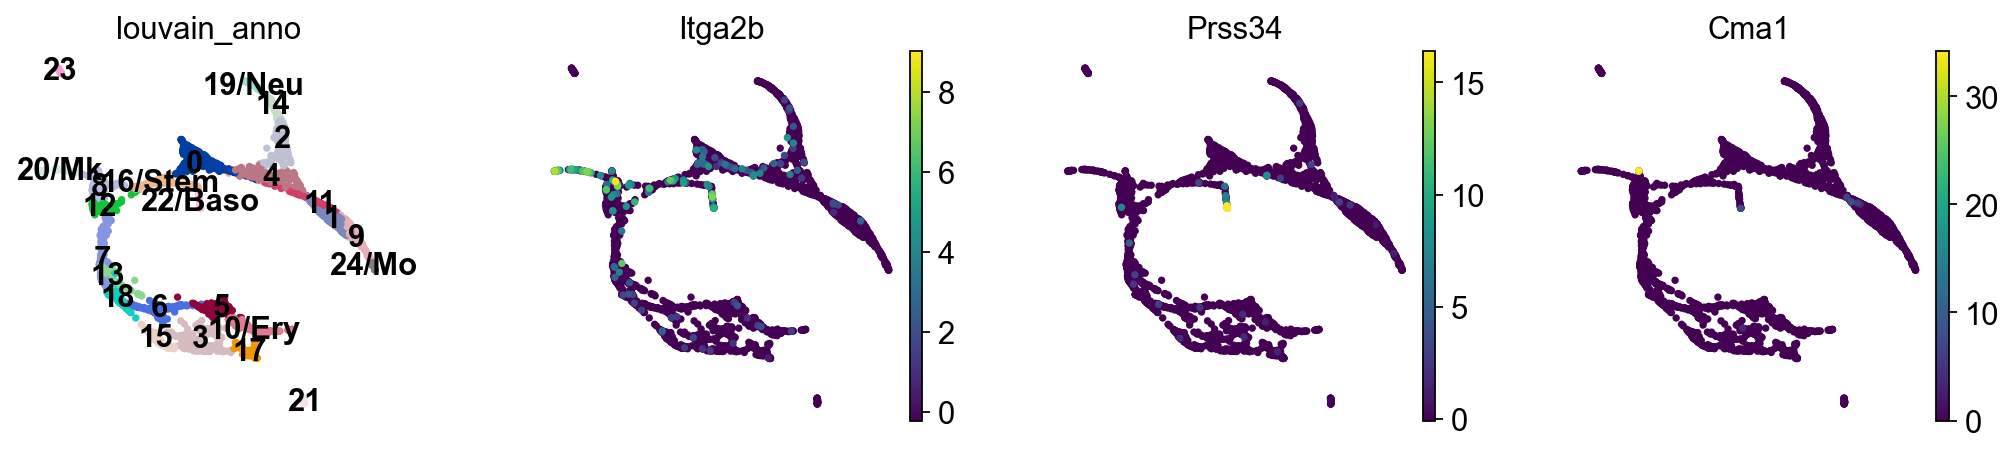

In [23]:
sc.pl.draw_graph(adata, color=['louvain_anno', 'Itga2b', 'Prss34', 'Cma1'], legend_loc='on data')

Choose the colors of the clusters a bit more consistently.

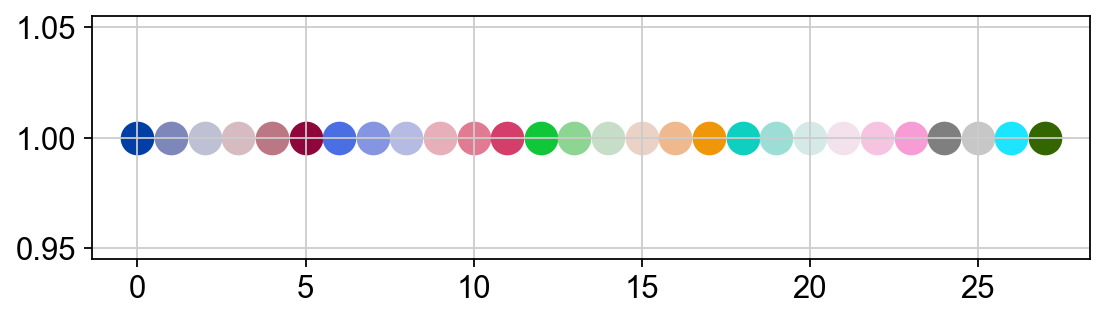

In [24]:
pl.figure(figsize=(8, 2))
for i in range(28):
    pl.scatter(i, 1, c=sc.pl.palettes.zeileis_28[i], s=200)
pl.show()
#
# s: size of the dots

In [25]:
zeileis_colors = np.array(sc.pl.palettes.zeileis_28) # new marker colors 
new_colors = np.array(adata.uns['louvain_anno_colors']) # original marker colors

Changing original marker colors

In [26]:
new_colors[[16]] = zeileis_colors[[12]]  # Stem colors / green
new_colors[[10, 17, 5, 3, 15, 6, 18, 13, 7, 12]] = zeileis_colors[[5, 5, 5, 5, 11, 11, 10, 9, 21, 21]]  # Ery colors / red
new_colors[[20, 8]] = zeileis_colors[[17, 16]]  # Mk early Ery colors / yellow
new_colors[[4, 0]] = zeileis_colors[[2, 8]]  # lymph progenitors / grey
new_colors[[22]] = zeileis_colors[[18]]  # Baso / turquoise
new_colors[[19, 14, 2]] = zeileis_colors[[6, 6, 6]]  # Neu / light blue
new_colors[[24, 9, 1, 11]] = zeileis_colors[[0, 0, 0, 0]]  # Mo / dark blue
new_colors[[21, 23]] = zeileis_colors[[25, 25]]  # outliers / grey

In [27]:
adata.uns['louvain_anno_colors'] = new_colors # update marker colors

And add some white space to some cluster names. The layout shown here differs from the one in the paper, which can be found here. These differences, however, are only cosmetic. We had to change the layout as we moved from a randomized PCA and float32 to float64 precision.

--> added 'pos', the PAGA positions (adata.uns['paga'])


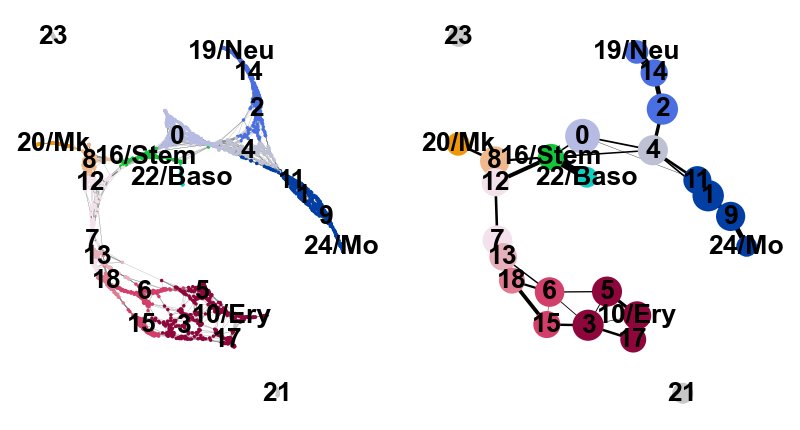

In [28]:
sc.pl.paga_compare(
    adata, threshold=0.03, title='', right_margin=0.2, size=10, edge_width_scale=0.5,
    legend_fontsize=12, fontsize=12, frameon=False, edges=True, save=True)
# paga_compare: Scatter(left image) and PAGA（right image） graph side-by-side.
# Consists in a scatter plot and the abstracted graph. 

Marker colors have been updated

# Reconstructing gene changes along PAGA paths for a given set of genes

Choose a root cell for diffusion pseudotime. 

**Diffusion pseudotime (DPT):** measures transitions between cells using diffusion-like random walks

In [29]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['louvain_anno']  == '16/Stem')[0]

In [30]:
sc.tl.dpt(adata)
# dpt: Infer progression of cells through geodesic distance along the graph [Haghverdi16] [Wolf19].

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


Select some of the marker gene names.

In [31]:
gene_names = ['Gata2', 'Gata1', 'Klf1', 'Epor', 'Hba-a2',  # erythroid
              'Elane', 'Cebpe', 'Gfi1',                    # neutrophil
              'Irf8', 'Csf1r', 'Ctsg']                     # monocyte

Use the full raw data for visualization.

In [32]:
adata_raw = sc.datasets.paul15() # use paul15 data
sc.pp.log1p(adata_raw)
# loglp: Logarithmize the data matrix.
sc.pp.scale(adata_raw)
# scale: Scale data to unit variance and zero mean.
adata.raw = adata_raw

C:\Users\gubow\anaconda3\lib\site-packages\anndata\_core\anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'paul15_clusters' as categorical
C:\Users\gubow\anaconda3\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.uns` of view, copying.


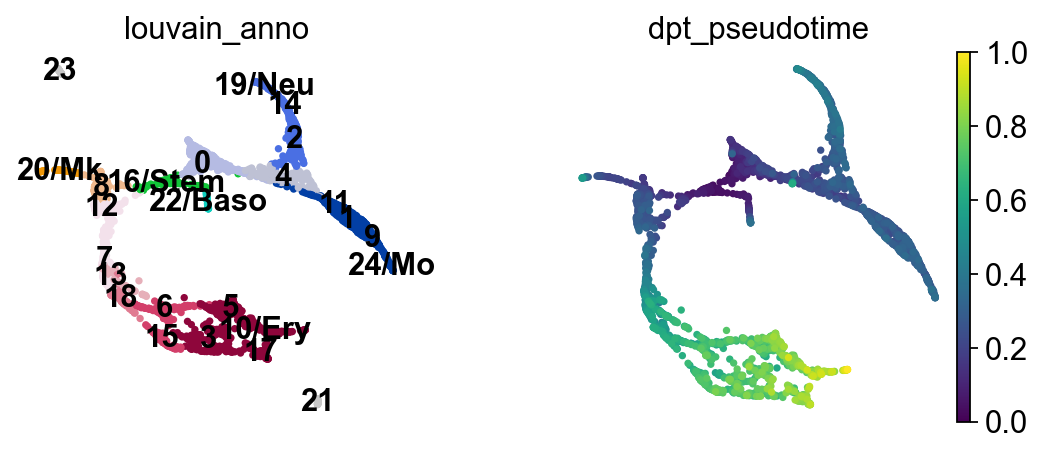

In [33]:
sc.pl.draw_graph(adata, color=['louvain_anno', 'dpt_pseudotime'], legend_loc='on data')

In [34]:
paths = [('erythrocytes', [16, 12, 7, 13, 18, 6, 5, 10]),
         ('neutrophils', [16, 0, 4, 2, 14, 19]),
         ('monocytes', [16, 0, 4, 11, 1, 9, 24])]
# manually set path from 16/stem to other cells(10, 19, 24)

In [35]:
adata.obs['distance'] = adata.obs['dpt_pseudotime']

In [36]:
adata.obs['clusters'] = adata.obs['louvain_anno']  # just a cosmetic change
# updated labels

In [37]:
adata.uns['clusters_colors'] = adata.uns['louvain_anno_colors']
# updated colors

In [38]:
!mkdir write

A subdirectory or file write already exists.


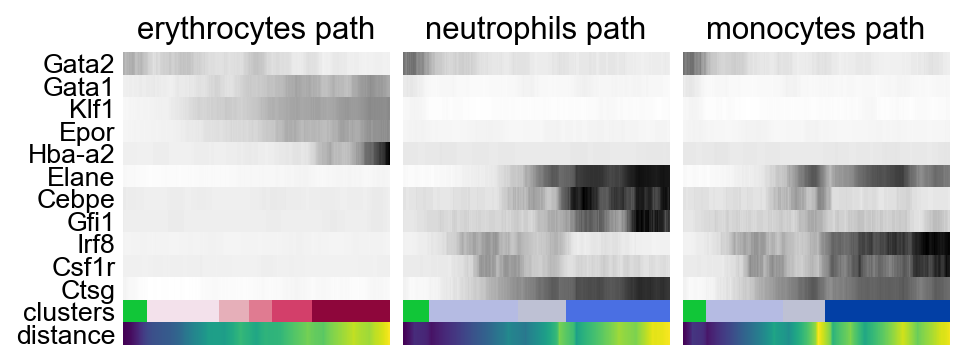

In [39]:
_, axs = pl.subplots(ncols=3, figsize=(6, 2.5), gridspec_kw={'wspace': 0.05, 'left': 0.12})
pl.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path( # paga_path: Gene expression and annotation changes along paths in the abstracted graph.
        adata, path, gene_names,                         
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['distance'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='Greys',
        groups_key='clusters',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        return_data=True,
        show=False)
    data.to_csv('./write/paga_path_{}.csv'.format(descr))
pl.savefig('./figures/paga_path_paul15.pdf')
pl.show()

We can see the pathes above and find that how stem cells become other type of cells